# Jared Godar Regression Project

This is the overall working notebook used to acquire / prepare / clean / scale / and explore my zillo data.

The modeling and evaluation portion will be in a second notebook `zillo-modeling.ipynb`

Streamlined highlights from both notebooks can be found in the `zillo-report.ipynb` notebook.

Import libraries used in project.

In [1]:
# Basic libraries
import pandas as pd
import numpy as np 

#Vizualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling Tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

from datetime import date
from scipy import stats


## Evaluation tools
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

#Custim functions
from env import host, user, password #Database credentials
import zillo_wrangle
import z_wrangle2
import z_wrangle3
import eval_model




---

## Acquire

In [2]:
# function to contact database
def get_db_url(db_name):
    return f"mysql+pymysql://{user}:{password}@{host}/{db_name}"

- Look at zillow data dictionary. 
- Import minimum features (beds, bath, tax, year, fips)
- See what other columns may prove useful in model


In [7]:
dd = pd.read_excel('zillow_data_dictionary.xlsx')
dd

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the buildi...
6,'buildingclasstypeid',"The building framing type (steel frame, wood f..."
7,'calculatedbathnbr',Number of bathrooms in home including fractio...
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + si...


### Takeaways: Columns of interest that may have predictive value

- `buildingqualitytypeid` Quality 
- `fireplacecnt`
- `garagecarcnt`
- `poolcnt`
- `rawcensustractandblock`
- `censustractandblock`
- `regionidzip`
- `regionidneighborhood`
- `storytypeid`


import:
- `regionidcounty`
- 
- `

Use SQL query to get single unit (`propertylandusetypeid=261`) from May-Aug, 2017 filtering for non-zero values to have fewer nulls in the first data pull to deal with.

In [8]:
def get_data_from_sql():
    query = """
    SELECT bedroomcnt as bedrooms, 
       bathroomcnt as bathrooms,
       calculatedfinishedsquarefeet as square_feet,
       yearbuilt as year,
       taxamount as taxes,
       taxvaluedollarcnt as home_value,
       fips as fips,
       regionidzip as zip_code
    FROM predictions_2017
     JOIN properties_2017 USING(parcelid)
    WHERE (transactiondate >= '2017-01-01' AND transactiondate <= '2017-12-31') 
        AND propertylandusetypeid = '261'
        AND bedroomcnt > 0
        AND bathroomcnt > 0
        AND calculatedfinishedsquarefeet > 0 
        AND taxamount > 0
        AND taxvaluedollarcnt > 0
        AND fips > 0
    ORDER BY fips;
    """
    df = pd.read_sql(query, get_db_url('zillow'))
    return df

In [9]:
zillow = get_data_from_sql()
zillow.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code
0,4.0,2.0,1544.0,1974.0,5419.26,430000.0,6037.0,96361.0
1,4.0,2.0,1749.0,1951.0,1432.09,96296.0,6037.0,96517.0
2,3.0,2.0,1441.0,1964.0,6194.07,469000.0,6037.0,96229.0
3,4.0,2.0,1196.0,1954.0,2140.24,113404.0,6037.0,97328.0
4,4.0,3.0,2117.0,2005.0,5635.97,253704.0,6037.0,97329.0


In [10]:
shape1 = zillow.shape
shape1

(52275, 8)

Count nulls by column

In [11]:
zillow.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52275 entries, 0 to 52274
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     52275 non-null  float64
 1   bathrooms    52275 non-null  float64
 2   square_feet  52275 non-null  float64
 3   year         52242 non-null  float64
 4   taxes        52275 non-null  float64
 5   home_value   52275 non-null  float64
 6   fips         52275 non-null  float64
 7   zip_code     52252 non-null  float64
dtypes: float64(8)
memory usage: 3.2 MB


In [12]:
zillow.zip_code.value_counts()

97319.0    774
97318.0    671
97329.0    564
97328.0    519
97118.0    498
          ... 
96434.0      2
96038.0      1
96467.0      1
96148.0      1
97092.0      1
Name: zip_code, Length: 379, dtype: int64

In [13]:
# get total of null values for each row
null1 = zillow.isnull().sum()
null1

bedrooms        0
bathrooms       0
square_feet     0
year           33
taxes           0
home_value      0
fips            0
zip_code       23
dtype: int64

Lots of missing neighborhood data... Drop that column before filtering NAs. (Actually removed this field from the SQL query - now not imported and not dropped)

- [ ] Drop city as well
- [ ] Figure out how to get that information from `fips`  

GO back to mysql workbench and see how many properties have the `single residential inferred` code 279

- 55614 for single family

- 0 records for inferred single family, so no need to include it in query

---

### Vizualize distribution and outliers

- Eliminating outliers may also reduce the null value counts

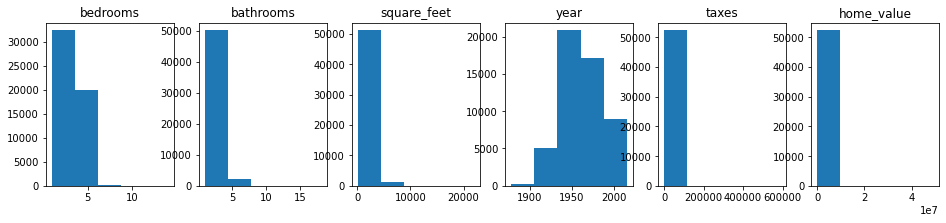

In [14]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in zillow.columns if col not in ['fips', 'year_built', 'zip_code', 'propertylandusedesc']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    zillow[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

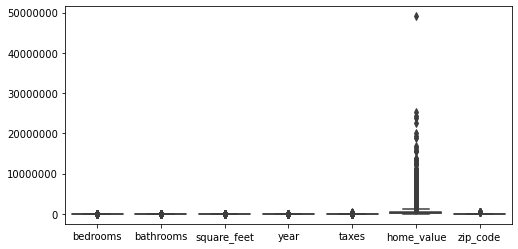

In [15]:
plt.figure(figsize=(8,4))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=zillow.drop(columns=['fips']))

plt.show()

Lots of outliers - especially in value

In [16]:
zillow.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))


,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code
count,52275,52275,52275,52242,52275,52275,52275,52252
mean,3.30967,2.30524,1923.5,1963.42,6435.26,528108,6049.1,96635.9
std,0.934916,1.01783,1004.07,23.118,8708.08,748325,21.0024,4612.21
min,1,1,152,1878,49.18,1000,6037,95982
25%,3,2,1268,1950,2659.39,193986,6037,96206
50%,3,2,1659,1961,4647.72,373611,6037,96412
75%,4,3,2306,1979,7371.41,618575,6059,96995
max,14,18,21929,2016,586639,4.90612e+07,6111,399675


### Remove outliers

Make remove outliers function

In [17]:
def remove_outliers(df, k, col_list):
    ''' remove outliers specified columns in a dataframe given a user-enterd cutoff value
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [18]:
zillow.dtypes

bedrooms       float64
bathrooms      float64
square_feet    float64
year           float64
taxes          float64
home_value     float64
fips           float64
zip_code       float64
dtype: object

In [19]:
zillow = remove_outliers(zillow, 1.5, ['bedrooms', 'bathrooms', 'square_feet', 'taxes', 'home_value'])
zillow.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code
0,4.0,2.0,1544.0,1974.0,5419.26,430000.0,6037.0,96361.0
1,4.0,2.0,1749.0,1951.0,1432.09,96296.0,6037.0,96517.0
2,3.0,2.0,1441.0,1964.0,6194.07,469000.0,6037.0,96229.0
3,4.0,2.0,1196.0,1954.0,2140.24,113404.0,6037.0,97328.0
4,4.0,3.0,2117.0,2005.0,5635.97,253704.0,6037.0,97329.0


In [20]:
shape2 = zillow.shape
print(shape1)
print(shape2)

(52275, 8)
(44953, 8)


In [21]:
removed1 = shape1[0]-shape2[0]

In [22]:
print(f'Original records: {shape1[0]}')
print(f'Records Removed: {removed1}')
print(f'Records remaining: {shape2[0]}')

Original records: 52275
Records Removed: 7322
Records remaining: 44953


In [23]:
# get total of null values for each row
null2 = zillow.isnull().sum()
print(null1)
print(null2)

bedrooms        0
bathrooms       0
square_feet     0
year           33
taxes           0
home_value      0
fips            0
zip_code       23
dtype: int64
bedrooms        0
bathrooms       0
square_feet     0
year           20
taxes           0
home_value      0
fips            0
zip_code       12
dtype: int64


Reasonable number of null values copared to total records, go ahead and drop NAs

In [24]:
# Drop NAs
zillow = zillow.dropna()

In [25]:
shape3=zillow.shape
shape3

(44922, 8)

In [26]:
removed2=shape2[0]-shape3[0]

In [27]:
print(f'Original records: {shape2[0]}')
print(f'Records Removed: {removed2}')
print(f'Records remaining: {shape3[0]}')

Original records: 44953
Records Removed: 31
Records remaining: 44922


---

### Vizualize distributions again minus outliers

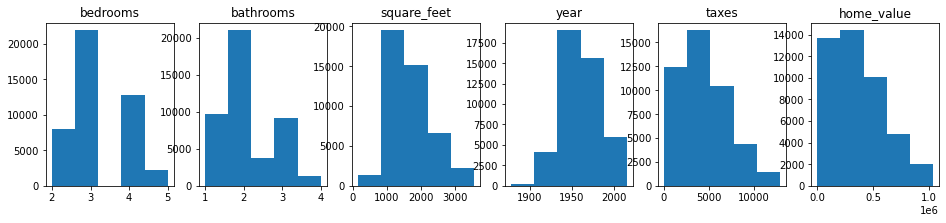

In [28]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in zillow.columns if col not in ['fips', 'zip_code', 'propertylandusedesc']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    zillow[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

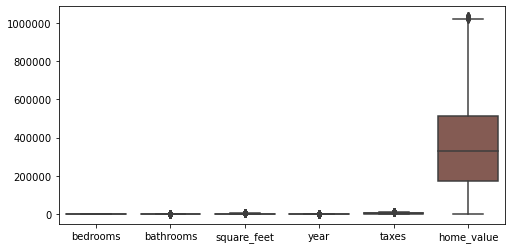

In [29]:
plt.figure(figsize=(8,4))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=zillow.drop(columns=['fips', 'zip_code']))

plt.show()

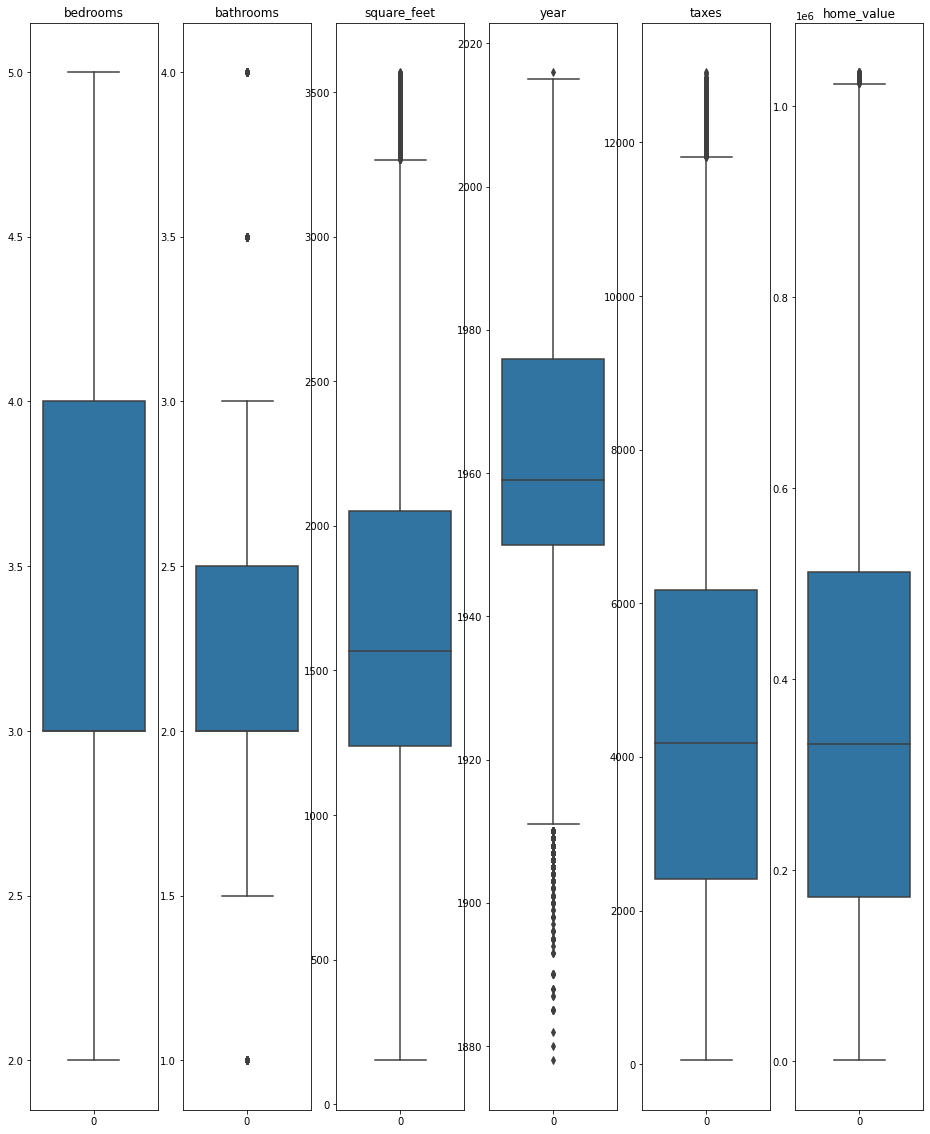

In [30]:
# List of columns
cols = [col for col in zillow.columns if col not in ['fips','zip_code', 'propertylandusedesc']]
plt.figure(figsize=(16, 20))
for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=zillow[col])

    # Hide gridlines.
    plt.grid(False)

plt.show()

In [31]:
zillow.dtypes

bedrooms       float64
bathrooms      float64
square_feet    float64
year           float64
taxes          float64
home_value     float64
fips           float64
zip_code       float64
dtype: object

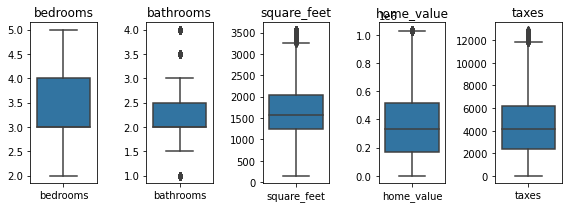

In [32]:
# List of columns
cols = ['bedrooms', 'bathrooms', 'square_feet', 'home_value', 'taxes']

plt.figure(figsize=(8, 3))

for i, col in enumerate(cols):

    # i starts at 0, but plot should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=zillow[[col]])

    # Hide gridlines.
    plt.grid(False)

    # sets proper spacing between plots
    plt.tight_layout()
    
plt.show()

In [33]:
# function to clean up my zillow df
def clean_data(df):
    '''
    This funciton takes in the zillow df and drops observations with Null values
    and handles data types returning a df with a basic clean.
    '''
    df = df.dropna()
    df['fips'] = df['fips'].astype(int)
    df['zip_code'] = df['zip_code'].astype(int)
    df['square_feet'] = df['square_feet'].astype(int)
    df['year'] = df['year'].astype(int)

    return df

In [34]:
zillow.shape

(44922, 8)

In [35]:
zillow = clean_data(zillow)

In [36]:
zillow.shape

(44922, 8)

In [37]:
zillow = clean_data(zillow)
print(zillow.shape)
zillow.head()

(44922, 8)


,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code
0,4.0,2.0,1544,1974,5419.26,430000.0,6037,96361
1,4.0,2.0,1749,1951,1432.09,96296.0,6037,96517
2,3.0,2.0,1441,1964,6194.07,469000.0,6037,96229
3,4.0,2.0,1196,1954,2140.24,113404.0,6037,97328
4,4.0,3.0,2117,2005,5635.97,253704.0,6037,97329


In [38]:
zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,44922.0,3.207627,0.788099,2.00,3.00,3.000,4.000,5.0
bathrooms,44922.0,2.094876,0.723171,1.00,2.00,2.000,2.500,4.0
square_feet,44922.0,1693.854815,604.667105,152.00,1239.00,1568.000,2050.000,3569.0
year,44922.0,1962.004296,21.656313,1878.00,1950.00,1959.000,1976.000,2016.0
taxes,44922.0,4520.645624,2661.273572,49.18,2416.52,4187.085,6174.595,12915.8
home_value,44922.0,363835.711433,233135.067981,1000.00,171663.50,331832.500,512491.000,1035555.0
fips,44922.0,6049.076176,21.146089,6037.00,6037.00,6037.000,6059.000,6111.0
zip_code,44922.0,96624.216932,3806.712065,95982.00,96213.00,96424.000,97004.000,399675.0


### To Do in successve iterations beyond MVP

- [ ] (for unchecked checkbox)
- [x] (for checked checkbox)


- [ ] Add column for range...
- [ ] Import additional columns of potential use
- [ ] Derive columns from there
    - Pool (boolean)
    - Condition (bins)
    - Calculate age in years
    - Bin ages
    - Etc.
- [ ] Lookup / populate county based on `fips`
- [ ] Caculate tax rate percent (`taxes`, `home_value`)


-[] Add "inferred single family residential" code to original SQL query (not necessary, 0 records)

- [x] left join on propertylandusetype



Minor, but kind of annoying find out why `[ ]` is not rendering as a checkbox in markdown in VS Code...

---

## County Data for Question

Fips codes can be found [here](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)

What fips are used in dataset?

In [39]:
zillow.fips.value_counts()

6037    29295
6059    11806
6111     3821
Name: fips, dtype: int64

In [40]:
29295+11806+3821

44922

In [41]:
zillow.shape

(44922, 8)

### Fips values 

| fips |   County    | State |
| :--: | :---------: | :---: |
| 6037 | Los Angeles |  CA   |
| 6059 |   Orange    |  CA   |
| 6111 |   Ventura   |  CA   |

In [42]:
zillow.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code
0,4.0,2.0,1544,1974,5419.26,430000.0,6037,96361
1,4.0,2.0,1749,1951,1432.09,96296.0,6037,96517
2,3.0,2.0,1441,1964,6194.07,469000.0,6037,96229
3,4.0,2.0,1196,1954,2140.24,113404.0,6037,97328
4,4.0,3.0,2117,2005,5635.97,253704.0,6037,97329


In [43]:
zillow.dtypes

bedrooms       float64
bathrooms      float64
square_feet      int64
year             int64
taxes          float64
home_value     float64
fips             int64
zip_code         int64
dtype: object

In [44]:
# Define function to add county based on fips by row

def assign_county(row):
    if row['fips']==6037:
        return 'Los Angeles'
    if row['fips']==6059:
        return 'Orange'
    if row['fips']==6111:
        return 'Ventura'

In [45]:
#Use function to assign county

zillow['county'] = zillow.apply(lambda row: assign_county(row), axis =1)

In [46]:
#Add state columns

zillow['state'] = 'CA'

In [47]:
zillow.sample(50)

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code,county,state
8281,4.0,3.0,2005,1944,6580.39,440562.0,6037,96480,Los Angeles,CA
24534,2.0,1.0,1188,1925,8321.92,697859.0,6037,96126,Los Angeles,CA
45437,3.0,2.0,1563,1957,5910.68,480415.0,6059,97050,Orange,CA
49521,3.0,2.0,1680,1956,4506.20,426410.0,6111,97083,Ventura,CA
17454,4.0,3.0,2670,1980,2864.26,161025.0,6037,97329,Los Angeles,CA
18266,3.0,2.0,1536,1982,3292.92,198000.0,6037,97328,Los Angeles,CA
32099,2.0,1.0,943,1942,4354.85,360449.0,6037,96127,Los Angeles,CA
3056,4.0,3.0,2061,1979,6338.00,498100.0,6037,96403,Los Angeles,CA
9769,3.0,2.0,1326,1955,881.00,53386.0,6037,96523,Los Angeles,CA
50916,4.0,2.0,1393,1964,3501.22,324572.0,6111,97084,Ventura,CA


In [48]:
## COnvert year into integer (May delete or comment out later since I added this to an earlier function)

zillow['year'] = zillow['year'].astype(int)


In [49]:
# Confrim year dtype changed

zillow.dtypes

bedrooms       float64
bathrooms      float64
square_feet      int64
year             int64
taxes          float64
home_value     float64
fips             int64
zip_code         int64
county          object
state           object
dtype: object

### Add county averages to DF

In [50]:
# Split into 3 county dataframes

la = zillow[zillow.county=='Los Angeles']
oc = zillow[zillow.county=='Orange']
ven = zillow[zillow.county=='Ventura']

In [51]:
# Calculate average home price by county

la_avg = la.home_value.mean()
oc_avg = oc.home_value.mean()
ven_avg = ven.home_value.mean()


In [52]:
# Add average county price as column

def assign_county_avg(row):
    if row['fips']==6037:
        return la_avg
    if row['fips']==6059:
        return oc_avg
    if row['fips']==6111:
        return ven_avg

In [53]:
zillow['county_avg'] = zillow.apply(lambda row: assign_county_avg(row), axis =1)

In [54]:
zillow.sample(25)

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code,county,state,county_avg
45048,3.0,2.0,1357,1959,1514.32,89133.0,6059,96958,Orange,CA,430173.980010
17229,3.0,1.0,998,1955,1889.35,94761.0,6037,97329,Los Angeles,CA,329837.159652
49496,4.0,2.0,1708,1978,11075.98,1002000.0,6111,97097,Ventura,CA,419527.408794
147,3.0,1.0,1008,1952,3158.03,249653.0,6037,96338,Los Angeles,CA,329837.159652
7332,4.0,3.0,2800,1998,8423.65,623000.0,6037,96398,Los Angeles,CA,329837.159652
36313,5.0,3.5,2496,1968,8795.42,851794.0,6059,96995,Orange,CA,430173.980010
14087,4.0,3.0,2541,1999,9166.29,556000.0,6037,96398,Los Angeles,CA,329837.159652
5323,3.0,2.0,2086,1984,3901.09,269133.0,6037,97319,Los Angeles,CA,329837.159652
44350,3.0,2.5,1601,1986,8076.68,760385.0,6059,96978,Orange,CA,430173.980010
46013,3.0,2.0,1421,1951,3397.28,256263.0,6059,96990,Orange,CA,430173.980010


---

### Feature engineering

- Will explore more later, but any initial features?
- Transform year built to age

In [55]:
from datetime import date


In [56]:
## add age column
zillow['age'] = date.today().year-zillow.year

In [57]:
# Confirm

zillow.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code,county,state,county_avg,age
0,4.0,2.0,1544,1974,5419.26,430000.0,6037,96361,Los Angeles,CA,329837.159652,47
1,4.0,2.0,1749,1951,1432.09,96296.0,6037,96517,Los Angeles,CA,329837.159652,70
2,3.0,2.0,1441,1964,6194.07,469000.0,6037,96229,Los Angeles,CA,329837.159652,57
3,4.0,2.0,1196,1954,2140.24,113404.0,6037,97328,Los Angeles,CA,329837.159652,67
4,4.0,3.0,2117,2005,5635.97,253704.0,6037,97329,Los Angeles,CA,329837.159652,16


## Location Data

- One-hot encode county so I can pass that to models

In [59]:
# Add this to clean module

dummy_df = pd.get_dummies(zillow[['county']], drop_first=True)
zillow = pd.concat([zillow, dummy_df], axis=1)

In [60]:
zillow.sample(25)

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code,county,state,county_avg,age,county_Orange,county_Ventura,county_Orange,county_Ventura
40305,4.0,2.5,3125,1990,9710.30,852991.0,6059,97067,Orange,CA,430173.980010,31,1,0,1,0
47615,3.0,2.0,1292,1960,5434.94,419213.0,6059,97052,Orange,CA,430173.980010,61,1,0,1,0
12924,3.0,2.0,1318,1952,5658.06,490000.0,6037,96523,Los Angeles,CA,329837.159652,69,0,0,0,0
52161,4.0,2.0,1669,1964,3839.78,364078.0,6111,97084,Ventura,CA,419527.408794,57,0,1,0,1
37777,4.0,2.5,2371,1969,2063.18,170492.0,6059,96957,Orange,CA,430173.980010,52,1,0,1,0
41861,4.0,2.0,1505,1966,5880.06,498092.0,6059,96958,Orange,CA,430173.980010,55,1,0,1,0
10559,2.0,1.0,768,1950,1614.94,108762.0,6037,96193,Los Angeles,CA,329837.159652,71,0,0,0,0
23793,5.0,3.0,1909,1952,3703.59,299912.0,6037,96171,Los Angeles,CA,329837.159652,69,0,0,0,0
31254,3.0,1.0,1210,1952,2093.67,151903.0,6037,96212,Los Angeles,CA,329837.159652,69,0,0,0,0
10392,3.0,2.0,1181,1955,1697.44,77229.0,6037,97317,Los Angeles,CA,329837.159652,66,0,0,0,0


### Add Tax rate column

taxes = home_value * tax_rate

tax_rate = taxes / home_value

In [61]:
zillow['tax_rate']=round(((zillow.taxes/zillow.home_value)*100),2)

In [62]:
zillow.sample(25)

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code,county,state,county_avg,age,county_Orange,county_Ventura,county_Orange,county_Ventura,tax_rate
8263,3.0,4.0,2459,1984,9080.04,831173.0,6037,96326,Los Angeles,CA,329837.159652,37,0,0,0,0,1.09
21348,5.0,3.0,1462,1954,5065.95,283969.0,6037,96090,Los Angeles,CA,329837.159652,67,0,0,0,0,1.78
42968,2.0,2.0,2010,1980,4042.46,348205.0,6059,97043,Orange,CA,430173.980010,41,1,0,1,0,1.16
50497,3.0,3.0,2197,1976,4848.16,454874.0,6111,97089,Ventura,CA,419527.408794,45,0,1,0,1,1.07
7602,3.0,2.0,1568,1950,4464.72,356905.0,6037,96210,Los Angeles,CA,329837.159652,71,0,0,0,0,1.25
29095,2.0,2.0,1648,1954,10893.90,903893.0,6037,96424,Los Angeles,CA,329837.159652,67,0,0,0,0,1.21
20745,3.0,2.0,2144,1942,7676.05,636852.0,6037,96247,Los Angeles,CA,329837.159652,79,0,0,0,0,1.21
17479,3.0,2.0,1586,2002,3665.53,239000.0,6037,97319,Los Angeles,CA,329837.159652,19,0,0,0,0,1.53
39367,4.0,3.0,1622,1955,5009.90,451305.0,6059,97065,Orange,CA,430173.980010,66,1,0,1,0,1.11
8560,3.0,2.0,1769,1957,3888.34,318209.0,6037,96354,Los Angeles,CA,329837.159652,64,0,0,0,0,1.22


In [63]:
zillow.tax_rate.min()

0.02

In [64]:
zillow.tax_rate.max()

81.65

---

## Split data into train, test, validate; Then create separate x/y feature/target dataframes


In [65]:
def split_my_data(df, pct=0.10):
    '''
    This splits a dataframe into train, validate, and test sets. 
    df = dataframe to split
    pct = size of the test set, 1/2 of size of the validate set
    Returns three dataframes (train, validate, test)
    '''
    train_validate, test = train_test_split(df, test_size=pct, random_state = 123)
    train, validate = train_test_split(train_validate, test_size=pct*2, random_state = 123)
    return train, validate, test

In [66]:
train, validate, test = split_my_data(zillow)

In [67]:
print(train.shape)
print(validate.shape)
print(test.shape)

(32343, 17)
(8086, 17)
(4493, 17)


## Baseline

- Can go ahead and add a baseline, y_hat prediction
- Will use the training median as baseline, less sensitive to outliers.

In [68]:
## Baseline

baseline = train.home_value.median()
baseline


330453.0

In [69]:
train['baseline'] = baseline
validate['baseline'] = baseline
test['baseline'] = baseline

In [70]:
train.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code,county,state,county_avg,age,county_Orange,county_Ventura,county_Orange,county_Ventura,tax_rate,baseline
41341,4.0,3.0,2897,1969,7103.04,707082.0,6059,96995,Orange,CA,430173.98001,52,1,0,1,0,1.00,330453.0
36463,3.0,2.0,1520,1968,7405.90,666000.0,6059,97008,Orange,CA,430173.98001,53,1,0,1,0,1.11,330453.0
42414,3.0,2.5,1551,1989,8227.20,609150.0,6059,96993,Orange,CA,430173.98001,32,1,0,1,0,1.35,330453.0
44293,4.0,3.0,2400,1987,8241.88,819623.0,6059,96987,Orange,CA,430173.98001,34,1,0,1,0,1.01,330453.0
35826,3.0,2.0,1546,1973,862.68,83402.0,6059,96995,Orange,CA,430173.98001,48,1,0,1,0,1.03,330453.0


In [71]:
# Split into x / y | features / target

# Setup X and y
X_train = train.drop(columns='home_value')
y_train = train.home_value

X_validate = validate.drop(columns='home_value')
y_validate = validate.home_value

X_test = test.drop(columns='home_value')
y_test = test.home_value

---

## Data has been aquired and cleaned, now scale

Since even our cleaned data has a fair number of outliers still, I will use the robust scaler

### Beginning exploration

- Examine pairwaise relationships
    - Crosstabs
    - Corr plots
    - Pair plots
    - Etc.

In [72]:
import sklearn.preprocessing
from sklearn.model_selection import train_test_split


In [73]:
train.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code,county,state,county_avg,age,county_Orange,county_Ventura,county_Orange,county_Ventura,tax_rate,baseline
41341,4.0,3.0,2897,1969,7103.04,707082.0,6059,96995,Orange,CA,430173.98001,52,1,0,1,0,1.00,330453.0
36463,3.0,2.0,1520,1968,7405.90,666000.0,6059,97008,Orange,CA,430173.98001,53,1,0,1,0,1.11,330453.0
42414,3.0,2.5,1551,1989,8227.20,609150.0,6059,96993,Orange,CA,430173.98001,32,1,0,1,0,1.35,330453.0
44293,4.0,3.0,2400,1987,8241.88,819623.0,6059,96987,Orange,CA,430173.98001,34,1,0,1,0,1.01,330453.0
35826,3.0,2.0,1546,1973,862.68,83402.0,6059,96995,Orange,CA,430173.98001,48,1,0,1,0,1.03,330453.0


In [74]:
train.dtypes

bedrooms          float64
bathrooms         float64
square_feet         int64
year                int64
taxes             float64
home_value        float64
fips                int64
zip_code            int64
county             object
state              object
county_avg        float64
age                 int64
county_Orange       uint8
county_Ventura      uint8
county_Orange       uint8
county_Ventura      uint8
tax_rate          float64
baseline          float64
dtype: object

**NOTE:** I originally scaled `fips` and `zip_code` because I wanted to pass more granular location data to my model. However, using a scaled value imploes a numberic relationship between the values (90210 being 100 more somethings from 90110, which is not the case). So, I am eliminating them from the scaler.

- To get in more granular location data, in a sucessive iteration I will one-hot encode the counties to pass along to the model

- To dive in finer:
    - Pull lat lon from the original database and see how many nulls there are
    - Convert zip to lat lon
    - Use an unsupervised clustering algorithm to create k neighborhoods
    - Explore approppriate k for number of obeservations; 3-6?

In [75]:
# Fit scaler to training data

scaler = sklearn.preprocessing.RobustScaler()

columns = ['bedrooms', 'bathrooms', 'square_feet',  'age']

scaler.fit(X_train[columns])


RobustScaler()

In [76]:
# Apply scaler to all data

new_column_names = [c + '_scaled' for c in columns]

X_train = pd.concat([X_train, pd.DataFrame(scaler.transform(X_train[columns]), columns=new_column_names, index = train.index),], axis=1)

X_validate = pd.concat([X_validate, pd.DataFrame(scaler.transform(X_validate[columns]), columns=new_column_names, index = validate.index),], axis=1)

X_test = pd.concat([X_test, pd.DataFrame(scaler.transform(X_test[columns]), columns=new_column_names, index = test.index),], axis=1)



In [77]:
X_train.sample(25)

,bedrooms,bathrooms,square_feet,year,taxes,fips,zip_code,county,state,county_avg,...,county_Orange,county_Ventura,county_Orange,county_Ventura,tax_rate,baseline,bedrooms_scaled,bathrooms_scaled,square_feet_scaled,age_scaled
38168,4.0,2.0,1418,1959,887.44,6059,97023,Orange,CA,430173.980010,...,1,0,1,0,1.57,330453.0,1.0,0.0,-0.183498,0.000000
3807,3.0,3.0,2046,2003,5567.16,6037,96373,Los Angeles,CA,329837.159652,...,0,0,0,0,1.34,330453.0,0.0,2.0,0.589901,-1.629630
44018,3.0,3.5,2272,1990,5111.26,6059,96951,Orange,CA,430173.980010,...,1,0,1,0,1.02,330453.0,0.0,3.0,0.868227,-1.148148
49987,4.0,3.0,3187,1986,6161.62,6111,97118,Ventura,CA,419527.408794,...,0,1,0,1,1.14,330453.0,1.0,2.0,1.995074,-1.000000
10272,2.0,1.0,895,1938,2050.01,6037,96239,Los Angeles,CA,329837.159652,...,0,0,0,0,1.31,330453.0,-1.0,-2.0,-0.827586,0.777778
44175,3.0,2.0,1352,1956,5758.44,6059,97020,Orange,CA,430173.980010,...,1,0,1,0,1.17,330453.0,0.0,0.0,-0.264778,0.111111
30943,4.0,3.0,3522,2004,7856.87,6037,97319,Los Angeles,CA,329837.159652,...,0,0,0,0,1.33,330453.0,1.0,2.0,2.407635,-1.666667
4965,3.0,3.0,1992,1967,4833.77,6037,96420,Los Angeles,CA,329837.159652,...,0,0,0,0,1.24,330453.0,0.0,2.0,0.523399,-0.296296
32433,4.0,2.0,1418,1950,1206.47,6037,96244,Los Angeles,CA,329837.159652,...,0,0,0,0,1.31,330453.0,1.0,0.0,-0.183498,0.333333
13895,4.0,3.0,2540,1969,8197.16,6037,96370,Los Angeles,CA,329837.159652,...,0,0,0,0,1.23,330453.0,1.0,2.0,1.198276,-0.370370


In [78]:
X_train.shape

(32343, 21)

Text(0.5, 1.0, 'Scaled')

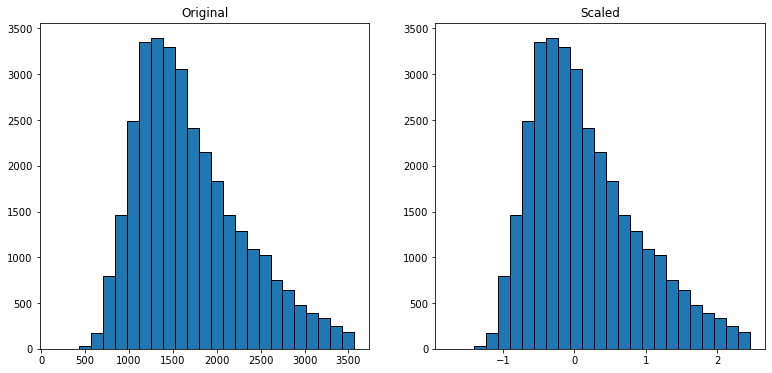

In [79]:
#Vizualize scaler

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train.square_feet, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train.square_feet_scaled, bins=25, ec='black')
plt.title('Scaled')

Text(0.5, 1.0, 'Scaled')

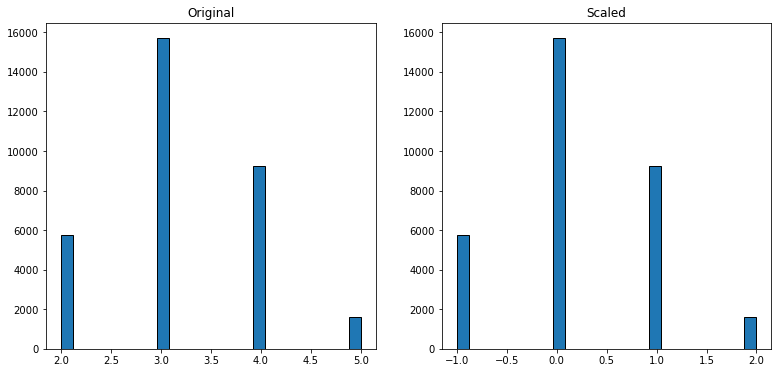

In [80]:
#Vizualize scaler

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train.bedrooms, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train.bedrooms_scaled, bins=25, ec='black')
plt.title('Scaled')

Text(0.5, 1.0, 'Scaled')

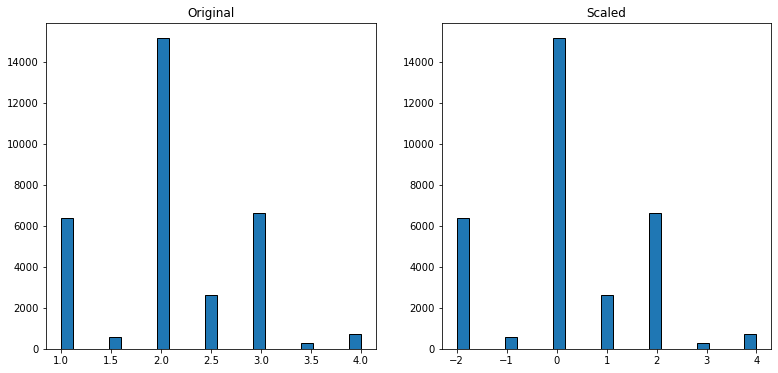

In [81]:
#Vizualize scaler

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train.bathrooms, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train.bathrooms_scaled, bins=25, ec='black')
plt.title('Scaled')

Text(0.5, 1.0, 'Scaled')

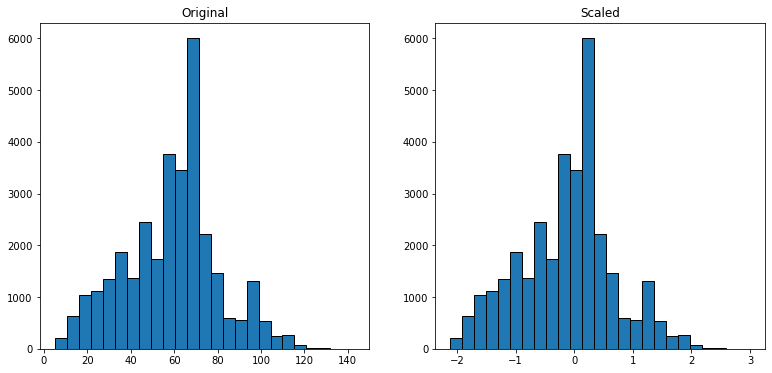

In [82]:
#Vizualize scaler

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train.age, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train.age_scaled, bins=25, ec='black')
plt.title('Scaled')

In [83]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,32343.0,3.207340,0.788294,2.000000,3.000000,3.000000,4.000000,5.000000
bathrooms,32343.0,2.095956,0.724407,1.000000,2.000000,2.000000,2.500000,4.000000
square_feet,32343.0,1694.147080,605.120623,152.000000,1239.000000,1567.000000,2051.000000,3569.000000
year,32343.0,1962.103856,21.598490,1878.000000,1950.000000,1959.000000,1977.000000,2016.000000
taxes,32343.0,4515.669671,2662.932088,49.180000,2413.450000,4171.820000,6167.530000,12915.800000
fips,32343.0,6049.028507,21.103361,6037.000000,6037.000000,6037.000000,6059.000000,6111.000000
zip_code,32343.0,96633.879789,4149.417832,95982.000000,96213.000000,96424.000000,97004.000000,399675.000000
county_avg,32343.0,363741.263023,46601.081557,329837.159652,329837.159652,329837.159652,430173.980010,430173.980010
age,32343.0,58.896144,21.598490,5.000000,44.000000,62.000000,71.000000,143.000000
county_Orange,32343.0,0.262313,0.439899,0.000000,0.000000,0.000000,1.000000,1.000000


___

In [84]:
########## Combine all of the above steps into function(s)#################

#################### IMPORT LIBRARIES #################

# Basic libraries
import pandas as pd
import numpy as np 

#Vizualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling Tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

from datetime import date

import sklearn.preprocessing
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

#Custim functions
from env import host, user, password #Database credentials
import zillo_wrangle





################ PULL DATA FROM DB ############## 

def get_db_url(db_name):
    return f"mysql+pymysql://{user}:{password}@{host}/{db_name}"


def get_data_from_sql():
    query = """
    SELECT bedroomcnt as bedrooms, 
       bathroomcnt as bathrooms,
       calculatedfinishedsquarefeet as square_feet,
       yearbuilt as year,
       taxamount as taxes,
       taxvaluedollarcnt as home_value,
       fips as fips,
       regionidzip as zip_code
    FROM predictions_2017
     JOIN properties_2017 USING(parcelid)
    WHERE (transactiondate >= '2017-01-01' AND transactiondate <= '2017-12-31') 
        AND propertylandusetypeid = '261'
        AND bedroomcnt > 0
        AND bathroomcnt > 0
        AND calculatedfinishedsquarefeet > 0 
        AND taxamount > 0
        AND taxvaluedollarcnt > 0
        AND fips > 0
    ORDER BY fips;
    """
    df = pd.read_sql(query, get_db_url('zillow'))
    return df


################ REMOVE OUTLIERS #################

def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

######## Clean Data ###########

def clean_data(df):
    '''
    This funciton takes in the zillow df and drops  Null values reassigns some dtypes.
    '''
    df = df.dropna()
    df['fips'] = df['fips'].astype(int)
    df['zip_code'] = df['zip_code'].astype(int)
    df['square_feet'] = df['square_feet'].astype('int')
    df['year'] = df['year'].astype(int)

    return df

######### ADD COUNTY AND STATE COLUMNS #######

def assign_county(row):
    if row['fips']==6037:
        return 'Los Angeles'
    if row['fips']==6059:
        return 'Orange'
    if row['fips']==6111:
        return 'Ventura'

######## Feature engineering ########

def engineer(zillow):
    zillow['county'] = zillow.apply(lambda row: assign_county(row), axis =1) #Add counties
    zillow['state'] = 'CA' #Add state
    zillow['age'] = date.today().year-zillow.year # Add age
    dummy_df = pd.get_dummies(zillow[['county']], drop_first=True)
    zillow = pd.concat([zillow, dummy_df], axis=1)
    return zillow

###### ADD COUNTY AVERAGE #############

def county_avg(zillow):
    la = zillow[zillow.county=='Los Angeles']
    oc = zillow[zillow.county=='Orange']
    ven = zillow[zillow.county=='Ventura']

    la_avg = la.home_value.mean()
    oc_avg = oc.home_value.mean()
    ven_avg = ven.home_value.mean()

    def assign_county_avg(row):
        if row['fips']==6037:
            return la_avg
        if row['fips']==6059:
            return oc_avg
        if row['fips']==6111:
            return ven_avg

    zillow['county_avg'] = zillow.apply(lambda row: assign_county_avg(row), axis =1)

    return zillow

########## TRAIN VALIDATE TEST SPLIT #########

def split_my_data(df, pct=0.10):
    '''
    This splits a dataframe into train, validate, and test sets. 
    df = dataframe to split
    pct = size of the test set, 1/2 of size of the validate set
    Returns three dataframes (train, validate, test)
    '''
    train_validate, test = train_test_split(df, test_size=pct, random_state = 123)
    train, validate = train_test_split(train_validate, test_size=pct*2, random_state = 123)
    return train, validate, test

########## ADD BASELINE #########

def add_baseline(train, validate, test):
    baseline = train.home_value.median()
    train['baseline'] = baseline
    validate['baseline'] = baseline
    test['baseline'] = baseline
    return train, validate, test

######## SPLIT IN TO X /y features / target ########

def split_xy(train, validate, test):
    X_train = train.drop(columns='home_value')
    y_train = train.home_value

    X_validate = validate.drop(columns='home_value')
    y_validate = validate.home_value

    X_test = test.drop(columns='home_value')
    y_test = test.home_value

    return X_train, y_train, X_validate, y_validate, X_test, y_test

############## Robust Scale ###############

def scale(X_train, X_validate, X_test, train, validate, test):
    scaler = sklearn.preprocessing.RobustScaler()

    columns = ['bedrooms', 'bathrooms', 'square_feet', 'fips', 'age', 'zip_code']
    
    scaler.fit(X_train[columns])

    new_column_names = [c + '_scaled' for c in columns]

    X_train = pd.concat([X_train, pd.DataFrame(scaler.transform(X_train[columns]), columns=new_column_names, index = train.index),], axis=1)

    X_validate = pd.concat([X_validate, pd.DataFrame(scaler.transform(X_validate[columns]), columns=new_column_names, index = validate.index),], axis=1)

    X_test = pd.concat([X_test, pd.DataFrame(scaler.transform(X_test[columns]), columns=new_column_names, index = test.index),], axis=1)
    
    return X_train, X_validate, X_test

######### CALL ALL FUNCTIONS TOGETHER #######

def wrangle():
    zillow = get_data_from_sql()
    zillow = remove_outliers(zillow, 1.5, ['bedrooms', 'bathrooms', 'square_feet', 'taxes', 'home_value'])
    zillow = clean_data(zillow) #Drop NAs and change dtypes
    zillow = engineer(zillow)
    zillow = county_avg(zillow)
    train, validate, test = split_my_data(zillow)
    train, validate, test = add_baseline(train, validate, test)
    X_train, y_train, X_validate, y_validate, X_test, y_test = split_xy(train, validate, test)
    X_train, X_validate, X_test = scale(X_train, X_validate, X_test, train, validate, test)
    return X_train, y_train, X_validate, y_validate, X_test, y_test








---

## EDA

### Initial questions:

1. What are drivers of tax value?
2. What leads to lower tax values?
3. What factors do not impact tax value?
4. Is there a difference in average price by county
5. Are there any ways to combine the current data into interesting engineered features?

In [85]:
X_train.sample(25)

,bedrooms,bathrooms,square_feet,year,taxes,fips,zip_code,county,state,county_avg,...,county_Orange,county_Ventura,county_Orange,county_Ventura,tax_rate,baseline,bedrooms_scaled,bathrooms_scaled,square_feet_scaled,age_scaled
32099,2.0,1.0,943,1942,4354.85,6037,96127,Los Angeles,CA,329837.159652,...,0,0,0,0,1.21,330453.0,-1.0,-2.0,-0.768473,0.629630
22543,2.0,1.0,870,1927,844.37,6037,96134,Los Angeles,CA,329837.159652,...,0,0,0,0,1.93,330453.0,-1.0,-2.0,-0.858374,1.185185
32045,4.0,2.0,1676,1962,2889.93,6037,96505,Los Angeles,CA,329837.159652,...,0,0,0,0,1.27,330453.0,1.0,0.0,0.134236,-0.111111
30304,2.0,1.0,854,1934,3114.57,6037,96172,Los Angeles,CA,329837.159652,...,0,0,0,0,1.30,330453.0,-1.0,-2.0,-0.878079,0.925926
36852,3.0,2.0,1780,1959,6781.58,6059,97021,Orange,CA,430173.980010,...,1,0,1,0,1.18,330453.0,0.0,0.0,0.262315,0.000000
43881,3.0,2.5,1730,1986,2562.96,6059,96987,Orange,CA,430173.980010,...,1,0,1,0,0.99,330453.0,0.0,1.0,0.200739,-1.000000
46478,2.0,1.5,1385,1978,3121.32,6059,97051,Orange,CA,430173.980010,...,1,0,1,0,1.31,330453.0,-1.0,-1.0,-0.224138,-0.703704
3145,4.0,3.0,3006,2006,9600.89,6037,96401,Los Angeles,CA,329837.159652,...,0,0,0,0,1.74,330453.0,1.0,2.0,1.772167,-1.740741
41632,5.0,3.0,2527,1964,1787.90,6059,96978,Orange,CA,430173.980010,...,1,0,1,0,1.24,330453.0,2.0,2.0,1.182266,-0.185185
28967,3.0,2.0,1696,1955,3485.93,6037,96474,Los Angeles,CA,329837.159652,...,0,0,0,0,1.29,330453.0,0.0,0.0,0.158867,0.148148


In [86]:
df= X_train

---

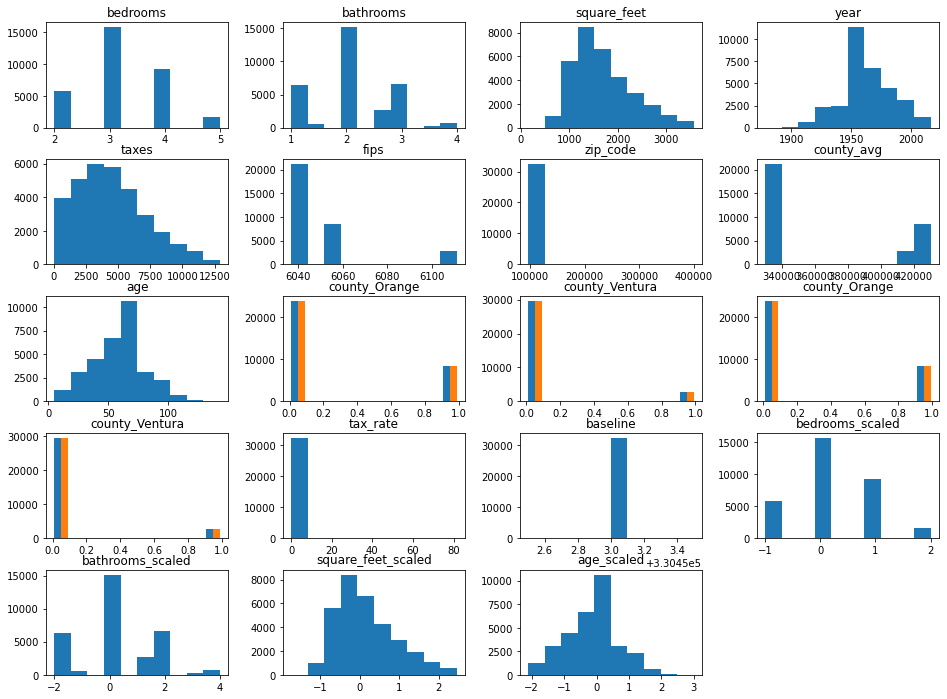

In [87]:
# Quick look at distribution of all numeric columns in df

df.hist(grid=False, figsize=(16,12));




In [88]:
df=train

<AxesSubplot:>

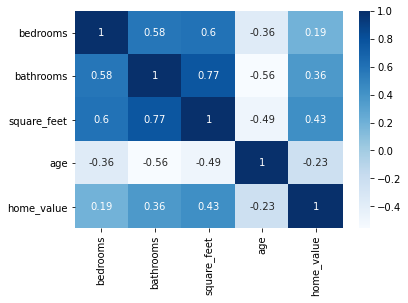

In [89]:
columns = ['bedrooms', 'bathrooms', 'square_feet', 'age', 'home_value']
sns.heatmap(df[columns].corr(), cmap='Blues', annot=True)



### Initial impressions

- Looking at factors that impact home value, Square footage seems to be the highest driver, followed by bathrooms, then bedrooms

- There is a negative correlation with age

- Bedrooms matter least out of these sparse columns

In [90]:
from scipy import stats

In [91]:
def correlation_exploration(df, x_string, y_string):
    r, p = stats.pearsonr(df[x_string], df[y_string])
    ax= sns.regplot(x=x_string, y=y_string, data=df, line_kws={"color": "red"})
    plt.title(f"{x_string}'s Relationship with {y_string}")
    print(f'The p-value is: {p}. There is {round(p,3)}% chance that we see these results by chance.')
    print(f'r = {round(r, 2)}')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.43


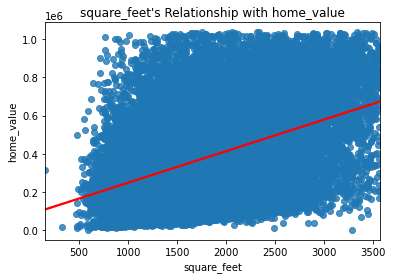

In [92]:
correlation_exploration(df, 'square_feet', 'home_value')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.36


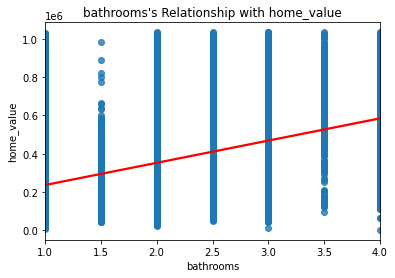

In [93]:
correlation_exploration(df, 'bathrooms', 'home_value')

The p-value is: 4.990842277914946e-272. There is 0.0% chance that we see these results by chance.
r = 0.19


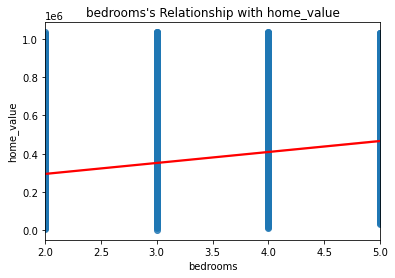

In [94]:
correlation_exploration(df, 'bedrooms', 'home_value')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = -0.23


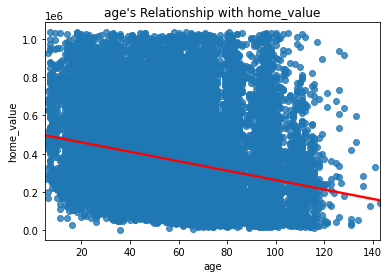

In [95]:
correlation_exploration(df, 'age', 'home_value')

- [x]Add lines of best fit to scatterplots

Statistical tests confirm, strongest correlation with area, followed by bathrooms, then bedrooms with age being negatively corrolated.

<AxesSubplot:xlabel='square_feet', ylabel='Count'>

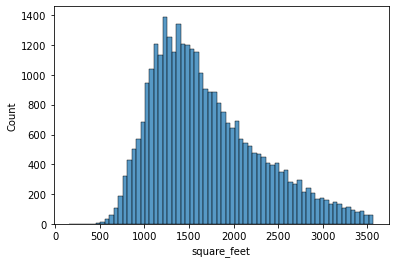

In [96]:
sns.histplot(data=df, x='square_feet')

<AxesSubplot:xlabel='Count', ylabel='bedrooms'>

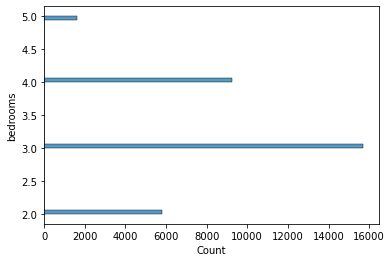

In [97]:
sns.histplot(data=df, y='bedrooms')

<AxesSubplot:xlabel='Count', ylabel='bathrooms'>

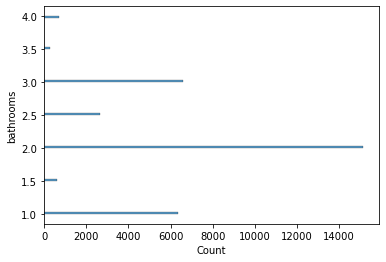

In [98]:
sns.histplot(data=df, y='bathrooms')

<AxesSubplot:xlabel='age', ylabel='Count'>

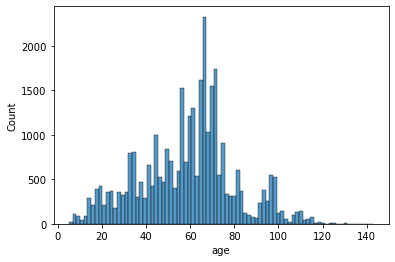

In [99]:
sns.histplot(data=df, x='age')

In [100]:
df.dtypes

bedrooms          float64
bathrooms         float64
square_feet         int64
year                int64
taxes             float64
home_value        float64
fips                int64
zip_code            int64
county             object
state              object
county_avg        float64
age                 int64
county_Orange       uint8
county_Ventura      uint8
county_Orange       uint8
county_Ventura      uint8
tax_rate          float64
baseline          float64
dtype: object

<AxesSubplot:xlabel='county', ylabel='Count'>

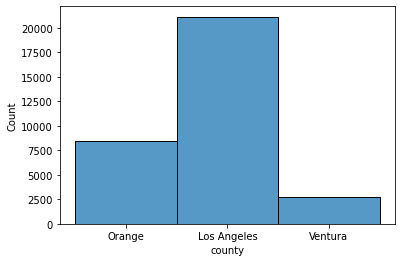

In [101]:
sns.histplot(data=df, x='county')

In [102]:

df['zip_code']=df['zip_code'].astype(int)

<AxesSubplot:xlabel='zip_code', ylabel='Count'>

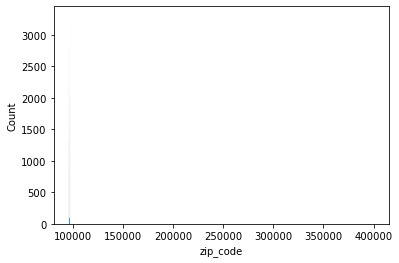

In [103]:
sns.histplot(data=df, x='zip_code')

weird scaling issues - play arond more if you really care to

Is there a difference in home prices by county?

In [104]:
# Make a separate dataframe for each county

la = train[train.county=='Los Angeles'].home_value
oc = train[train.county=='Orange'].home_value
ven = train[train.county=='Ventura'].home_value

Text(0.5, 1.0, 'Figure 5: Average value by County')

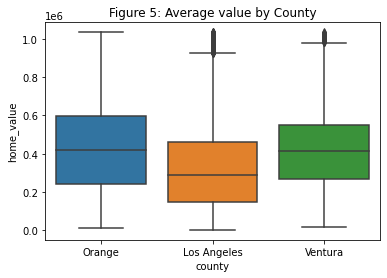

In [105]:
# Vizualize prices by county

ax = sns.boxplot(x=train.county, y=train.home_value)
#ax = sns.swarmplot(x=train.county, y=train.home_value, color ='.25')
plt.title('Figure 5: Average value by County')

- Perform Kruskal-Wallis H-test to see if there is a difference by county.

- Using a nonparametric test since the underlying distributions are not normal.

In [106]:
stats.kruskal(la, oc, ven)

KruskalResult(statistic=1357.533431618437, pvalue=1.6419533891990053e-295)

- There are differences by county. 

- Post-hoc, pairwaise analysis can determine which samples are different in which direction.

In [107]:
# Is LA lower than OC
stats.mannwhitneyu(la, oc, alternative ='less')

MannwhitneyuResult(statistic=67523869.0, pvalue=3.841782942079302e-242)

- Los Angeles County prices are lower, on average, than Orange County 

In [108]:
# Is LA lower than Ventura

stats.mannwhitneyu(la, ven, alternative ='less')

MannwhitneyuResult(statistic=21523832.5, pvalue=5.9695151055108555e-105)

- Los Angeles County prices are lower, on average, than Ventura County 

In [109]:
# Is Ventura Lower than Orange

stats.mannwhitneyu(ven, oc, alternative ='less')

MannwhitneyuResult(statistic=11424918.0, pvalue=0.11480778422845389)

Ventura is not statistically lower than orange

In [110]:
# Is there a difference between Ventura and orange

stats.mannwhitneyu(ven, oc)

MannwhitneyuResult(statistic=11424918.0, pvalue=0.11480778422845389)

In [111]:
stats.kruskal(oc, ven)

KruskalResult(statistic=1.443249323379644, pvalue=0.2296142522360047)

There is no statistically significant difference between the mean home values in Orange and Ventura Counties.

### Ideas for final figures:

- Figure 1 - Distributions: Panels with distributions of all target varibles
- Figure 2 - Drivers: panels with correlations and R/p labelled
- Figure 3 - Redce (age)
- Figure 4 - Don't matter

<AxesSubplot:xlabel='home_value', ylabel='Count'>

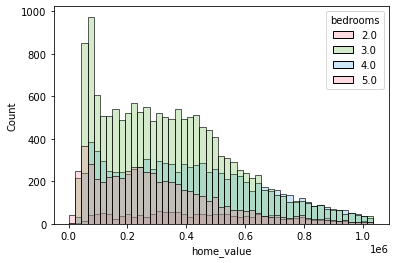

In [112]:
sns.histplot(data=df, x='home_value', hue='bedrooms', palette='husl', alpha = 0.25)

<AxesSubplot:xlabel='home_value', ylabel='Count'>

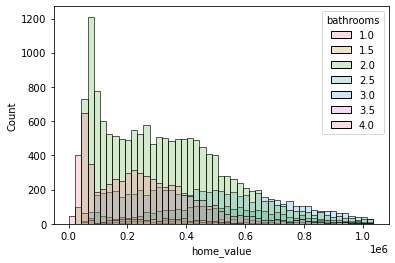

In [113]:
sns.histplot(data=df, x='home_value', hue='bathrooms', palette='husl', alpha = 0.25)

---

# Modeling

Data is now clean split, and scaled and we have a baseline and a feel for meaningful drivers. Proceed with creating MVP model.

In [114]:
# - Import ols


from statsmodels.formula.api import ols



In [115]:
# Create Model

ols_model = ols(formula='home_value ~ bedrooms + bathrooms + square_feet', data=train).fit()



In [116]:
# Make predictions

ols_yhat = ols_model.predict(X_train)



In [117]:
X_train['mvp_prdictions']=ols_yhat

In [118]:
X_train.sample(20)

,bedrooms,bathrooms,square_feet,year,taxes,fips,zip_code,county,state,county_avg,...,county_Ventura,county_Orange,county_Ventura,tax_rate,baseline,bedrooms_scaled,bathrooms_scaled,square_feet_scaled,age_scaled,mvp_prdictions
32289,4.0,3.0,2212,1956,7319.65,6037,96369,Los Angeles,CA,329837.159652,...,0,0,0,1.21,330453.0,1.0,2.0,0.794335,0.111111,449660.017566
7630,3.0,1.0,1018,1950,1375.42,6037,96117,Los Angeles,CA,329837.159652,...,0,0,0,1.21,330453.0,0.0,-2.0,-0.676108,0.333333,224097.267880
37873,4.0,2.5,2453,1978,2396.30,6059,96971,Orange,CA,430173.980010,...,0,1,0,1.01,330453.0,1.0,1.0,1.091133,-0.703704,471482.826256
45942,4.0,3.0,2326,1971,7696.00,6059,96941,Orange,CA,430173.980010,...,0,1,0,1.03,330453.0,1.0,2.0,0.934729,-0.444444,468064.336374
36521,5.0,3.0,2600,1996,11757.06,6059,96954,Orange,CA,430173.980010,...,0,1,0,1.18,330453.0,2.0,2.0,1.272167,-1.370370,476762.736308
19169,3.0,2.0,2034,1963,9177.28,6037,96327,Los Angeles,CA,329837.159652,...,0,0,0,1.09,330453.0,0.0,0.0,0.575123,-0.148148,422290.857293
17263,3.0,1.0,1219,1953,880.29,6037,96242,Los Angeles,CA,329837.159652,...,0,0,0,1.33,330453.0,0.0,-2.0,-0.428571,0.222222,256546.987883
25358,3.0,1.0,951,1924,3248.75,6037,95992,Los Angeles,CA,329837.159652,...,0,0,0,1.24,330453.0,0.0,-2.0,-0.758621,1.296296,213280.694545
21936,4.0,3.0,2214,1987,6295.94,6037,96403,Los Angeles,CA,329837.159652,...,0,0,0,1.53,330453.0,1.0,2.0,0.796798,-1.037037,449982.900352
30266,3.0,2.0,1176,1923,1443.32,6037,96107,Los Angeles,CA,329837.159652,...,0,0,0,1.65,330453.0,0.0,0.0,-0.481527,1.333333,283774.142054


In [119]:
y_train

41341    707082.0
36463    666000.0
42414    609150.0
44293    819623.0
35826     83402.0
           ...   
27215    395021.0
34200    696759.0
46904    364996.0
7907     168703.0
33723     79549.0
Name: home_value, Length: 32343, dtype: float64

---

### Evaluate model

- RMSE and R^2 will be primary evaluation metrics
- Make a dataframe with actual values, baseline predictions, and model predictions
- Calculate RMSE
- Calculate R^2

In [120]:
#  DataFrame for evaluating model 

ols_eval = y_train.copy()
validate_eval = y_validate.copy()

In [121]:
ols_eval = pd.DataFrame(ols_eval)
validate_eval = pd.DataFrame(validate_eval)

In [122]:
ols_eval.rename(columns={'home_value': 'actual'}, inplace=True)
validate_eval.rename(columns={'home_value': 'actual'}, inplace=True)



In [123]:
validate_eval

,actual
7575,167929.0
10957,80747.0
44026,121014.0
45491,370325.0
41191,42055.0
...,...
31252,600000.0
35576,122560.0
22454,64346.0
29003,385794.0


In [124]:
# Add baseline - median home value

ols_eval['baseline_yhat'] = ols_eval['actual'].median()

validate_eval['baseline_yhat'] = ols_eval['actual'].median()



In [125]:
# Add model prediction

ols_eval['ols_yhat'] = ols_model.predict(X_train)
validate_eval['ols_yhat'] = ols_model.predict(X_validate)



In [126]:
validate_eval

,actual,baseline_yhat,ols_yhat
7575,167929.0,330453.0,438036.237266
10957,80747.0,330453.0,338825.657085
44026,121014.0,330453.0,407580.255235
45491,370325.0,330453.0,448073.824263
41191,42055.0,330453.0,211504.839222
...,...,...,...
31252,600000.0,330453.0,304600.081758
35576,122560.0,330453.0,380477.536493
22454,64346.0,330453.0,261495.229812
29003,385794.0,330453.0,428530.630367


In [127]:
# Calculate and Add Residuals Column for Plotting

ols_eval['residuals'] = ols_eval.ols_yhat - ols_eval.actual
validate_eval['residuals'] = validate_eval.ols_yhat - validate_eval.actual



In [128]:
ols_eval

,actual,baseline_yhat,ols_yhat,residuals
41341,707082.0,330453.0,560247.371807,-146834.628193
36463,666000.0,330453.0,339309.981264,-326690.018736
42414,609150.0,330453.0,361399.231484,-247750.768516
44293,819623.0,330453.0,480010.999460,-339612.000540
35826,83402.0,330453.0,343507.457483,260105.457483
...,...,...,...,...
27215,395021.0,330453.0,323887.484078,-71133.515922
34200,696759.0,330453.0,512803.037541,-183955.962459
46904,364996.0,330453.0,331257.346902,-33738.653098
7907,168703.0,330453.0,216186.639620,47483.639620


In [129]:
#  Compute the RMSE  and R2 for  ols model and baseline 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

baseline_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.baseline_yhat)))
ols_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols_yhat)))
pct_change=round(((ols_RMSE-baseline_RMSE)/baseline_RMSE)*100, 2)
rmse_validate = round(sqrt(mean_squared_error(validate_eval.actual, validate_eval.ols_yhat)))
baseline_r2 = round(r2_score(ols_eval.actual, ols_eval.baseline_yhat), 2)
ols_train_r2 = round(r2_score(ols_eval.actual, ols_eval.ols_yhat), 2)
ols_validate_r2 = round(r2_score(validate_eval.actual, validate_eval.ols_yhat), 2)

print(f'My model has value: {ols_RMSE < baseline_RMSE}')
print()
print(f'Baseline RMSE: {baseline_RMSE}')
print(f'My model train RMSE: {ols_RMSE}')
print(f'My model validate RMSE: {rmse_validate}')
print(f'RMSE difference baseline to model: {baseline_RMSE- ols_RMSE}')
print(f'RMSE difference train to validate: {ols_RMSE- rmse_validate}')
print(f'RMSE improvement: {pct_change}%')
print()
print(f'Baseline R2: {baseline_r2}')
print(f'Model train  R2: {ols_train_r2}')
print(f'Model Validate R2: {ols_validate_r2}')



My model has value: True

Baseline RMSE: 235257
My model train RMSE: 209005
My model validate RMSE: 210823
RMSE difference baseline to model: 26252
RMSE difference train to validate: -1818
RMSE improvement: -11.16%

Baseline R2: -0.02
Model train  R2: 0.2
Model Validate R2: 0.19


In [130]:
ols_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             home_value   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     2611.
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:37:14   Log-Likelihood:            -4.4210e+05
No. Observations:               32343   AIC:                         8.842e+05
Df Residuals:                   32339   BIC:                         8.842e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.322e+05   4931.211     26.807      0.000    1.23e+05    1.42e+05
bedrooms    -3.554e+04   1894.259    -18.760      0.000   -3.92e+04   -3.18e+04
bathrooms    3.417e+04   2596.435     13.160      0.000    2.91e+04    3.93e+04
square_feet   161.4414      3.184     50.707      0.000     155.201     167.682
==============================================================================
Omnibus:                     1024.723   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1089.763
Skew:                           0.435   Prob(JB):                    2.30e-237
Kurtosis:                       2.774   Cond. No.                     7.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

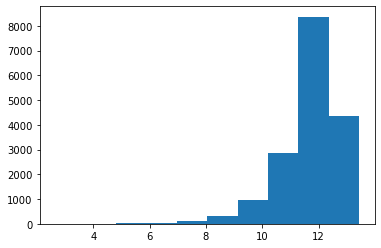

In [131]:
# Look at risiduals distribution

plt.hist(np.log(ols_eval.residuals));



Definitley a skew to the residuals - not centered around 0

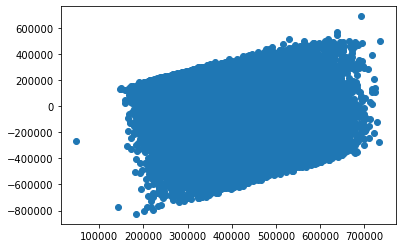

In [132]:
# Look at Predictions vs Residuals

plt.scatter(ols_eval.ols_yhat, ols_eval.residuals)

---

Next model: same as before, but add age

---

## OLS2: add age

In [133]:
train.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code,county,state,county_avg,age,county_Orange,county_Ventura,county_Orange,county_Ventura,tax_rate,baseline
41341,4.0,3.0,2897,1969,7103.04,707082.0,6059,96995,Orange,CA,430173.98001,52,1,0,1,0,1.00,330453.0
36463,3.0,2.0,1520,1968,7405.90,666000.0,6059,97008,Orange,CA,430173.98001,53,1,0,1,0,1.11,330453.0
42414,3.0,2.5,1551,1989,8227.20,609150.0,6059,96993,Orange,CA,430173.98001,32,1,0,1,0,1.35,330453.0
44293,4.0,3.0,2400,1987,8241.88,819623.0,6059,96987,Orange,CA,430173.98001,34,1,0,1,0,1.01,330453.0
35826,3.0,2.0,1546,1973,862.68,83402.0,6059,96995,Orange,CA,430173.98001,48,1,0,1,0,1.03,330453.0


In [134]:
ols2_model = ols(formula='home_value ~ bedrooms + bathrooms + square_feet + age',  data=train).fit() #Create model
ols2_yhat = ols2_model.predict(X_train) # Make predictions
X_train['model2']=ols2_yhat


In [135]:
# Add to eval
ols_eval['ols2_yhat'] = ols2_model.predict(X_train)
validate_eval['ols2_yhat'] = ols2_model.predict(X_validate)
ols_eval['ols2_residuals'] = ols_eval.ols2_yhat - ols_eval.actual
validate_eval['ols2_residuals'] = validate_eval.ols2_yhat - validate_eval.actual


In [136]:
baseline_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.baseline_yhat)))
ols_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols_yhat)))
ols2_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols2_yhat)))
pct_change_baseline=round(((ols_RMSE-baseline_RMSE)/baseline_RMSE)*100, 2)
pct_change_last_model=round(((ols2_RMSE-ols_RMSE)/ols_RMSE)*100, 2)
rmse_validate = round(sqrt(mean_squared_error(validate_eval.actual, validate_eval.ols2_yhat)))
baseline_r2 = round(r2_score(ols_eval.actual, ols_eval.baseline_yhat), 2)
ols2_train_r2 = round(r2_score(ols_eval.actual, ols_eval.ols2_yhat), 2)
ols2_validate_r2 = round(r2_score(validate_eval.actual, validate_eval.ols2_yhat), 2)


print(f'My model has value: {ols_RMSE < baseline_RMSE}')
print(f'My model beats previous model: {ols2_RMSE < ols_RMSE}')
print()
print(f'Baseline RMSE: {baseline_RMSE}')
print(f'Model 1 RMSE: {ols_RMSE}')
print(f'Currennt model train RMSE: {ols2_RMSE}')
print(f'Currennt model validate RMSE: {rmse_validate}')
print()
print(f'Current model RMSE difference from baseline: {baseline_RMSE- ols_RMSE}')
print(f'RMSE difference train to validate: {ols2_RMSE- rmse_validate}')
print(f'Current model baseline RMSE improvement: {pct_change_baseline}%')
print(f'Current model RMSE improvement from last model: {pct_change_last_model}%')
print()
print(f'Baseline R2: {baseline_r2}')
print(f'Model train  R2: {ols2_train_r2}')
print(f'Model Validate R2: {ols2_validate_r2}')




My model has value: True
My model beats previous model: True

Baseline RMSE: 235257
Model 1 RMSE: 209005
Currennt model train RMSE: 208989
Currennt model validate RMSE: 210802

Current model RMSE difference from baseline: 26252
RMSE difference train to validate: -1813
Current model baseline RMSE improvement: -11.16%
Current model RMSE improvement from last model: -0.01%

Baseline R2: -0.02
Model train  R2: 0.2
Model Validate R2: 0.19


In [137]:
ols_eval

,actual,baseline_yhat,ols_yhat,residuals,ols2_yhat,ols2_residuals
41341,707082.0,330453.0,560247.371807,-146834.628193,558632.745338,-148449.254662
36463,666000.0,330453.0,339309.981264,-326690.018736,340495.998005,-325504.001995
42414,609150.0,330453.0,361399.231484,-247750.768516,364667.963533,-244482.036467
44293,819623.0,330453.0,480010.999460,-339612.000540,481342.288959,-338280.711041
35826,83402.0,330453.0,343507.457483,260105.457483,345406.938138,262004.938138
...,...,...,...,...,...,...
27215,395021.0,330453.0,323887.484078,-71133.515922,324140.263014,-70880.736986
34200,696759.0,330453.0,512803.037541,-183955.962459,514722.253824,-182036.746176
46904,364996.0,330453.0,331257.346902,-33738.653098,333485.011999,-31510.988001
7907,168703.0,330453.0,216186.639620,47483.639620,219214.365943,50511.365943


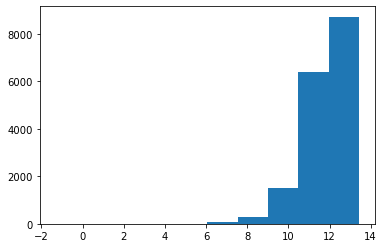

In [138]:
# Look at risiduals distribution

plt.hist(np.log(ols_eval.ols2_residuals));



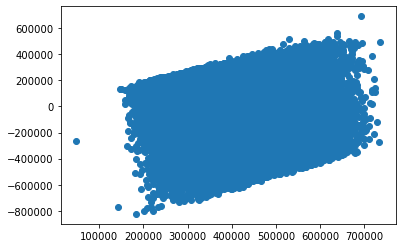

In [139]:
# Look at Predictions vs Residuals

plt.scatter(ols_eval.ols_yhat, ols_eval.ols2_residuals)

In [140]:
ols2_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             home_value   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     1960.
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:47:55   Log-Likelihood:            -4.4210e+05
No. Observations:               32343   AIC:                         8.842e+05
Df Residuals:                   32338   BIC:                         8.842e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.464e+05   8022.444     18.244      0.000    1.31e+05    1.62e+05
bedrooms    -3.568e+04   1895.159    -18.825      0.000   -3.94e+04    -3.2e+04
bathrooms    3.224e+04   2735.299     11.787      0.000    2.69e+04    3.76e+04
square_feet   160.8023      3.196     50.308      0.000     154.537     167.067
age          -146.0160     65.216     -2.239      0.025    -273.842     -18.191
==============================================================================
Omnibus:                     1047.539   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1119.057
Skew:                           0.442   Prob(JB):                    1.00e-243
Kurtosis:                       2.779   Cond. No.                     1.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 3: add county

In [141]:
train.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code,county,state,county_avg,age,county_Orange,county_Ventura,county_Orange,county_Ventura,tax_rate,baseline
41341,4.0,3.0,2897,1969,7103.04,707082.0,6059,96995,Orange,CA,430173.98001,52,1,0,1,0,1.00,330453.0
36463,3.0,2.0,1520,1968,7405.90,666000.0,6059,97008,Orange,CA,430173.98001,53,1,0,1,0,1.11,330453.0
42414,3.0,2.5,1551,1989,8227.20,609150.0,6059,96993,Orange,CA,430173.98001,32,1,0,1,0,1.35,330453.0
44293,4.0,3.0,2400,1987,8241.88,819623.0,6059,96987,Orange,CA,430173.98001,34,1,0,1,0,1.01,330453.0
35826,3.0,2.0,1546,1973,862.68,83402.0,6059,96995,Orange,CA,430173.98001,48,1,0,1,0,1.03,330453.0


In [142]:
ols3_model = ols(formula='home_value ~ bedrooms + bathrooms + square_feet + age + county_Orange + county_Ventura',  data=train).fit() #Create model
ols3_yhat = ols3_model.predict(X_train) # Make predictions
X_train['model3']=ols3_yhat

In [143]:
ols_eval

,actual,baseline_yhat,ols_yhat,residuals,ols2_yhat,ols2_residuals
41341,707082.0,330453.0,560247.371807,-146834.628193,558632.745338,-148449.254662
36463,666000.0,330453.0,339309.981264,-326690.018736,340495.998005,-325504.001995
42414,609150.0,330453.0,361399.231484,-247750.768516,364667.963533,-244482.036467
44293,819623.0,330453.0,480010.999460,-339612.000540,481342.288959,-338280.711041
35826,83402.0,330453.0,343507.457483,260105.457483,345406.938138,262004.938138
...,...,...,...,...,...,...
27215,395021.0,330453.0,323887.484078,-71133.515922,324140.263014,-70880.736986
34200,696759.0,330453.0,512803.037541,-183955.962459,514722.253824,-182036.746176
46904,364996.0,330453.0,331257.346902,-33738.653098,333485.011999,-31510.988001
7907,168703.0,330453.0,216186.639620,47483.639620,219214.365943,50511.365943


In [144]:
ols_eval['ols3_yhat'] = ols3_model.predict(X_train)
ols_eval['ols3_residuals'] = ols_eval.ols3_yhat - ols_eval.actual
validate_eval['ols3_yhat'] = ols3_model.predict(X_validate)
validate_eval['ols3_residuals'] = validate_eval.ols3_yhat - validate_eval.actual

In [145]:
validate_eval

,actual,baseline_yhat,ols_yhat,residuals,ols2_yhat,ols2_residuals,ols3_yhat,ols3_residuals
7575,167929.0,330453.0,438036.237266,270107.237266,433839.064126,265910.064126,418390.719530,250461.719530
10957,80747.0,330453.0,338825.657085,258078.657085,338699.446690,257952.446690,318596.905468,237849.905468
44026,121014.0,330453.0,407580.255235,286566.255235,407632.259519,286618.259519,446936.780286,325922.780286
45491,370325.0,330453.0,448073.824263,77748.824263,447507.398920,77182.398920,486497.739686,116172.739686
41191,42055.0,330453.0,211504.839222,169449.839222,212798.906585,170743.906585,259142.293835,217087.293835
...,...,...,...,...,...,...,...,...
31252,600000.0,330453.0,304600.081758,-295399.918242,308843.823498,-291156.176502,275383.371001,-324616.628999
35576,122560.0,330453.0,380477.536493,257917.536493,382230.665797,259670.665797,420170.177623,297610.177623
22454,64346.0,330453.0,261495.229812,197149.229812,260945.062759,196599.062759,244202.340760,179856.340760
29003,385794.0,330453.0,428530.630367,42736.630367,434287.836109,48493.836109,390141.766771,4347.766771


In [146]:
ols_eval

,actual,baseline_yhat,ols_yhat,residuals,ols2_yhat,ols2_residuals,ols3_yhat,ols3_residuals
41341,707082.0,330453.0,560247.371807,-146834.628193,558632.745338,-148449.254662,596874.436962,-110207.563038
36463,666000.0,330453.0,339309.981264,-326690.018736,340495.998005,-325504.001995,381336.194211,-284663.805789
42414,609150.0,330453.0,361399.231484,-247750.768516,364667.963533,-244482.036467,396866.815786,-212283.184214
44293,819623.0,330453.0,480010.999460,-339612.000540,481342.288959,-338280.711041,512041.855227,-307581.144773
35826,83402.0,330453.0,343507.457483,260105.457483,345406.938138,262004.938138,383815.833353,300413.833353
...,...,...,...,...,...,...,...,...
27215,395021.0,330453.0,323887.484078,-71133.515922,324140.263014,-70880.736986,309252.416348,-85768.583652
34200,696759.0,330453.0,512803.037541,-183955.962459,514722.253824,-182036.746176,546149.979330,-150609.020670
46904,364996.0,330453.0,331257.346902,-33738.653098,333485.011999,-31510.988001,374620.740430,9624.740430
7907,168703.0,330453.0,216186.639620,47483.639620,219214.365943,50511.365943,194561.789149,25858.789149


In [147]:
baseline_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.baseline_yhat)))
ols_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols_yhat)))
ols2_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols2_yhat)))
ols3_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols3_yhat)))

pct_change_baseline=round(((ols3_RMSE-baseline_RMSE)/baseline_RMSE)*100, 2)
pct_change_last_model=round(((ols3_RMSE-ols2_RMSE)/ols2_RMSE)*100, 2)

ols3_train_r2 = round(r2_score(ols_eval.actual, ols_eval.ols3_yhat), 2)
ols3_validate_r2 = round(r2_score(validate_eval.actual, validate_eval.ols3_yhat), 2)

print(f'My model has value: {ols3_RMSE < baseline_RMSE}')
print(f'My model beats previous model: {ols3_RMSE < ols2_RMSE}')
print()
print(f'Baseline RMSE: {baseline_RMSE}')
print(f'Model 1 RMSE: {ols_RMSE}')
print(f'Model 2 RMSE: {ols2_RMSE}')
print(f'Current model RMSE: {ols3_RMSE}')
print()
print(f'Current model RMSE difference from baseline: {baseline_RMSE- ols3_RMSE}')
print(f'Current model baseline RMSE improvement: {pct_change_baseline}%')
print(f'Current model RMSE improvement from last model: {pct_change_last_model}%')
print()
print(f'Baseline R2: {baseline_r2}')
print(f'Current Model train  R2: {ols3_train_r2}')
print(f'Current Model Validate R2: {ols3_validate_r2}')


My model has value: True
My model beats previous model: True

Baseline RMSE: 235257
Model 1 RMSE: 209005
Model 2 RMSE: 208989
Current model RMSE: 207035

Current model RMSE difference from baseline: 28222
Current model baseline RMSE improvement: -12.0%
Current model RMSE improvement from last model: -0.93%

Baseline R2: -0.02
Current Model train  R2: 0.21
Current Model Validate R2: 0.21


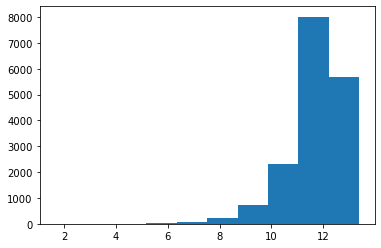

In [148]:
# Look at risiduals distribution

plt.hist(np.log(ols_eval.ols3_residuals));



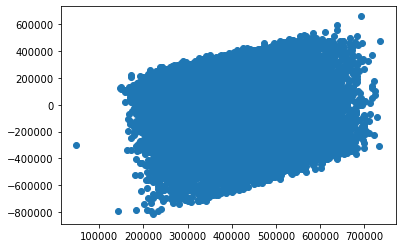

In [149]:
# Look at Predictions vs Residuals

plt.scatter(ols_eval.ols_yhat, ols_eval.ols3_residuals)

In [150]:
ols3_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             home_value   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     1433.
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:48:04   Log-Likelihood:            -4.4179e+05
No. Observations:               32343   AIC:                         8.836e+05
Df Residuals:                   32336   BIC:                         8.837e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.006e+05   8162.494     12.325      0.000    8.46e+04    1.17e+05
bedrooms           -3.78e+04   1881.092    -20.092      0.000   -4.15e+04   -3.41e+04
bathrooms          3.506e+04   2714.104     12.918      0.000    2.97e+04    4.04e+04
square_feet         158.7526      3.168     50.116      0.000     152.544     164.961
age                 329.5857     67.502      4.883      0.000     197.280     461.891
county_Orange[0]   3.261e+04   1397.602     23.336      0.000    2.99e+04    3.54e+04
county_Orange[1]   3.261e+04   1397.602     23.336      0.000    2.99e+04    3.54e+04
county_Ventura[0]  2.957e+04   2168.140     13.637      0.000    2.53e+04    3.38e+04
county_Ventura[1]  2.957e+04   2168.140     13.637      0.000    2.53e+04    3.38e+04
==============================================================================
Omnibus:                     1007.738   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1101.004
Skew:                           0.449   Prob(JB):                    8.32e-240
Kurtosis:                       2.903   Cond. No.                     2.93e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.22e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

RMSD went down firther and R^2 increased

[] Add RMSE for validate on model 3

---

### Takeaways / Feature Engineering

- MVP model beats baseline
- Now, try to beat model
- How? Feature engineering
- Potential features:
    - Incorporate location:
        - One-hot encoded counties for now
        - Future iterations: Cluster lat/lon for more granular location detail
    - Add boolean columns:
        - Garage / no garage
        - Pool / no pool
        - Etc.
    - Room score: some kind of single value incorporating both the bedrooms and bathrooms
        - Maybe multiplied / weighted by their correlation coefficients
    - Stratify columns:
        - Age: historical, new constuction, in between

- Build new, select * query to bring in more fields to use for engineering

### EVALUATION VIZUALS

- [] Better actual vs predicted plots
    - For a small enough sample of values you can see them
- []Residual plots
- [] Histograms of actual vs predicted

---

### LASSO / LARS

In [151]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [152]:
# create the model object
lars = LassoLars(alpha=1.0)

In [153]:
y_train=pd.DataFrame(y_train)

In [154]:
columns =['bedrooms_scaled', 'bathrooms_scaled','square_feet_scaled', 'age_scaled', 'county_Orange', 'county_Ventura']

In [155]:
X_train.dtypes

bedrooms              float64
bathrooms             float64
square_feet             int64
year                    int64
taxes                 float64
fips                    int64
zip_code                int64
county                 object
state                  object
county_avg            float64
age                     int64
county_Orange           uint8
county_Ventura          uint8
county_Orange           uint8
county_Ventura          uint8
tax_rate              float64
baseline              float64
bedrooms_scaled       float64
bathrooms_scaled      float64
square_feet_scaled    float64
age_scaled            float64
mvp_prdictions        float64
model2                float64
model3                float64
dtype: object

In [156]:
y_train

,home_value
41341,707082.0
36463,666000.0
42414,609150.0
44293,819623.0
35826,83402.0
...,...
27215,395021.0
34200,696759.0
46904,364996.0
7907,168703.0


In [157]:

lasso_lars = lars.fit(X_train[columns], y_train.home_value)

In [158]:
y_train['lars_predict']=lars.predict(X_train[columns])

In [159]:
rmse_train = sqrt(mean_squared_error(y_train.home_value, y_train.lars_predict))


In [160]:
rmse_train

207088.35795040225

Basely worse than model 3 above by RMSE, check R^2

In [161]:
from sklearn.metrics import r2_score

In [162]:
lars_r2 =r2_score(y_train.home_value, y_train.lars_predict)

In [163]:
lars_r2

0.20969742083957799

# TO DO 

- [X] Add R2 to printed summaries
- [] Hard Code Datafram of models with rmse and r2 for easy, side-by-side comparison

---

Using a separate wrangle file to feature engineer a more robust model beyond my MVP without breaking anything in that,

### Plan:
1. Use the same query - change only scalers
    -  Linear & Standard
    - See if it improves model
2. Import all the fields from the database, clean them up, and use K-best for modeling
    - Rename columns
    - Drop Columns
    - Engineer columns
    - Encode columns
    - Model

## Min-Max scaler

The robust scaler and min max scaler produced the same results. 

[ ] If time, Try again with standard scaler. For now, go to full database pull snd feature engineering.

---

Before doing the heavy-lifting feature engineering

- [] first try a polynomial model 
- [] Tweedie
    - power 0, 1, (1,2), 2, 3
- [] Re-run the Lasso with different $\alpha$ values

## Polynomial models

In [167]:
train, X_train, y_train, X_validate, y_validate, X_test, y_test = zillo_wrangle.wrangle()

In [ ]:
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor


In [ ]:
from sklearn.preprocessing import PolynomialFeatures


In [ ]:
columns=['bedrooms', 'bathrooms', 'square_feet', 'age']

# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train[columns])

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate[columns])


In [ ]:
# create the model object
lm2 = LinearRegression(normalize=True)


In [ ]:
xtr_df=pd.DataFrame(X_train_degree2)

In [ ]:


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train)


In [ ]:
y_train=pd.DataFrame(y_train)

In [ ]:

# predict train
y_train['pred_lm2'] = lm2.predict(X_train_degree2)


In [ ]:

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.pred_lm2)**(1/2)


In [ ]:
y_validate=pd.DataFrame(y_validate)

In [ ]:

# predict validate
y_validate['pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.pred_lm2)**(1/2)

lm2_validate_r2 = round(r2_score(y_validate.home_value, y_validate.pred_lm2), 2)


print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

print(f'Model Validate R2: {lm2_validate_r2}')



Similar R2, but higher RMSE than best current model

---

In [ ]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


In [ ]:

columns=['bedrooms', 'bathrooms', 'square_feet', 'age', 'county_Orange', 'county_Ventura']
# fit the model to our training data. 
glm.fit(X_train[columns], y_train.home_value)


In [ ]:

# predict train
y_train['pred_glm'] = glm.predict(X_train[columns])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.pred_glm)**(1/2)

glm_train_r2 = round(r2_score(y_train.home_value, y_train.pred_glm), 2)

# predict validate
y_validate['pred_glm'] = glm.predict(X_validate[columns])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.pred_glm)**(1/2)

# Evaluate R2

glm_validate_r2 = round(r2_score(y_validate.home_value, y_validate.pred_glm), 2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

print(f'Current Model train  R2: {glm_train_r2}')
print(f'Current Model Validate R2: {glm_validate_r2}')

In [ ]:
# Do a select * from the database and engineer features from there
import z_wrangle3

In [ ]:
zillow = z_wrangle3.get_data_from_sql()

In [ ]:
zillow.head()

Get NA counts to see what columns are usable